## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [9]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [15]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [16]:
import itertools

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3


W0726 02:09:29.938844 11216 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0726 02:09:29.949845 11216 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0726 02:09:30.055850 11216 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 4s 77us/step - loss: 0.7569 - acc: 0.7552 - val_loss: 1.5029 - val_acc: 0.5039
Epoch 47/50
50000/50000 [==============================] - 4s 77us/step - loss: 0.7447 - acc: 0.7593 - val_loss: 1.5028 - val_acc: 0.5026
Epoch 48/50
50000/50000 [==============================] - 4s 76us/step - loss: 0.7321 - acc: 0.7662 - val_loss: 1.4957 - val_acc: 0.5067

Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.0009227448242017999.
Epoch 49/50
50000/50000 [==============================] - 4s 77us/step - loss: 0.7183 - acc: 0.7724 - val_loss: 1.5278 - val_acc: 0.5038
Epoch 50/50
50000/50000 [==============================] - 4s 79us/step - loss: 0.7062 - acc: 0.7769 - val_loss: 1.5166 - val_acc: 0.5086
Numbers of exp: 1, reduce_factor: 0.99, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)          

50000/50000 [==============================] - 4s 81us/step - loss: 0.8131 - acc: 0.7343 - val_loss: 1.4875 - val_acc: 0.4979
Epoch 43/50
50000/50000 [==============================] - 4s 79us/step - loss: 0.7992 - acc: 0.7401 - val_loss: 1.4996 - val_acc: 0.5028
Epoch 44/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.7855 - acc: 0.7455 - val_loss: 1.5004 - val_acc: 0.5011
Epoch 45/50
50000/50000 [==============================] - 4s 80us/step - loss: 0.7723 - acc: 0.7507 - val_loss: 1.5011 - val_acc: 0.5026

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.000886384982150048.
Epoch 46/50
50000/50000 [==============================] - 4s 83us/step - loss: 0.7604 - acc: 0.7562 - val_loss: 1.5256 - val_acc: 0.4992
Epoch 47/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.7473 - acc: 0.7601 - val_loss: 1.5076 - val_acc: 0.5041
Epoch 48/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.7337 - acc: 0.7667 - v

Epoch 39/50
50000/50000 [==============================] - 4s 79us/step - loss: 0.8805 - acc: 0.7066 - val_loss: 1.4757 - val_acc: 0.4997
Epoch 40/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.8664 - acc: 0.7114 - val_loss: 1.4807 - val_acc: 0.4932
Epoch 41/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.8520 - acc: 0.7164 - val_loss: 1.4934 - val_acc: 0.4971
Epoch 42/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.8411 - acc: 0.7209 - val_loss: 1.4951 - val_acc: 0.4905
Epoch 43/50
50000/50000 [==============================] - 4s 81us/step - loss: 0.8255 - acc: 0.7272 - val_loss: 1.4925 - val_acc: 0.4953
Epoch 44/50
50000/50000 [==============================] - 4s 78us/step - loss: 0.8135 - acc: 0.7323 - val_loss: 1.5015 - val_acc: 0.4959
Epoch 45/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.7993 - acc: 0.7385 - val_loss: 1.5041 - val_acc: 0.4952
Epoch 46/50
50000/50000 [========

50000/50000 [==============================] - 4s 81us/step - loss: 0.9566 - acc: 0.6798 - val_loss: 1.4467 - val_acc: 0.5009
Epoch 37/50
50000/50000 [==============================] - 4s 79us/step - loss: 0.9510 - acc: 0.6818 - val_loss: 1.4485 - val_acc: 0.5038
Epoch 38/50
50000/50000 [==============================] - 4s 77us/step - loss: 0.9452 - acc: 0.6840 - val_loss: 1.4477 - val_acc: 0.5005
Epoch 39/50
50000/50000 [==============================] - 4s 78us/step - loss: 0.9431 - acc: 0.6858 - val_loss: 1.4516 - val_acc: 0.5030

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00010750730871222913.
Epoch 40/50
50000/50000 [==============================] - 4s 78us/step - loss: 0.9360 - acc: 0.6879 - val_loss: 1.4485 - val_acc: 0.5050
Epoch 41/50
50000/50000 [==============================] - 4s 79us/step - loss: 0.9333 - acc: 0.6893 - val_loss: 1.4477 - val_acc: 0.5049
Epoch 42/50
50000/50000 [==============================] - 4s 78us/step - loss: 0.9296 - acc: 0.6904 -

50000/50000 [==============================] - 4s 81us/step - loss: 1.9193 - acc: 0.3373 - val_loss: 1.9603 - val_acc: 0.3304
Epoch 33/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.9121 - acc: 0.3409 - val_loss: 1.9549 - val_acc: 0.3302
Epoch 34/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.9050 - acc: 0.3434 - val_loss: 1.9492 - val_acc: 0.3320
Epoch 35/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.8986 - acc: 0.3441 - val_loss: 1.9435 - val_acc: 0.3345
Epoch 36/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.8921 - acc: 0.3465 - val_loss: 1.9380 - val_acc: 0.3360
Epoch 37/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.8857 - acc: 0.3487 - val_loss: 1.9326 - val_acc: 0.3356
Epoch 38/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.8801 - acc: 0.3504 - val_loss: 1.9276 - val_acc: 0.3373
Epoch 39/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 81us/step - loss: 1.9525 - acc: 0.3283 - val_loss: 1.9943 - val_acc: 0.3094
Epoch 31/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.9440 - acc: 0.3302 - val_loss: 1.9873 - val_acc: 0.3120
Epoch 32/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.9363 - acc: 0.3331 - val_loss: 1.9805 - val_acc: 0.3126
Epoch 33/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.9280 - acc: 0.3359 - val_loss: 1.9743 - val_acc: 0.3142
Epoch 34/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.9211 - acc: 0.3374 - val_loss: 1.9682 - val_acc: 0.3158
Epoch 35/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.9140 - acc: 0.3390 - val_loss: 1.9618 - val_acc: 0.3185
Epoch 36/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.9073 - acc: 0.3418 - val_loss: 1.9573 - val_acc: 0.3208
Epoch 37/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 82us/step - loss: 1.9701 - acc: 0.3253 - val_loss: 1.9954 - val_acc: 0.3235
Epoch 29/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.9623 - acc: 0.3285 - val_loss: 1.9869 - val_acc: 0.3263
Epoch 30/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.9546 - acc: 0.3295 - val_loss: 1.9797 - val_acc: 0.3289
Epoch 31/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.9455 - acc: 0.3327 - val_loss: 1.9729 - val_acc: 0.3301
Epoch 32/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.9376 - acc: 0.3365 - val_loss: 1.9654 - val_acc: 0.3332
Epoch 33/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.9298 - acc: 0.3370 - val_loss: 1.9588 - val_acc: 0.3345
Epoch 34/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.9232 - acc: 0.3392 - val_loss: 1.9528 - val_acc: 0.3354
Epoch 35/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 85us/step - loss: 2.0044 - acc: 0.3201 - val_loss: 2.0259 - val_acc: 0.3132
Epoch 27/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.9936 - acc: 0.3240 - val_loss: 2.0174 - val_acc: 0.3151
Epoch 28/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.9842 - acc: 0.3256 - val_loss: 2.0098 - val_acc: 0.3172
Epoch 29/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.9768 - acc: 0.3278 - val_loss: 2.0021 - val_acc: 0.3193
Epoch 30/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.9680 - acc: 0.3302 - val_loss: 1.9954 - val_acc: 0.3214
Epoch 31/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.9593 - acc: 0.3327 - val_loss: 1.9883 - val_acc: 0.3241
Epoch 32/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.9507 - acc: 0.3341 - val_loss: 1.9815 - val_acc: 0.3254
Epoch 33/50
50000/50000 [===================

50000/50000 [==============================] - 4s 81us/step - loss: 2.0169 - acc: 0.3165 - val_loss: 2.0543 - val_acc: 0.3066
Epoch 25/50
50000/50000 [==============================] - 4s 81us/step - loss: 2.0051 - acc: 0.3207 - val_loss: 2.0450 - val_acc: 0.3112
Epoch 26/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.9957 - acc: 0.3227 - val_loss: 2.0354 - val_acc: 0.3125
Epoch 27/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.9862 - acc: 0.3245 - val_loss: 2.0264 - val_acc: 0.3159
Epoch 28/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.9768 - acc: 0.3277 - val_loss: 2.0175 - val_acc: 0.3182
Epoch 29/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.9674 - acc: 0.3288 - val_loss: 2.0089 - val_acc: 0.3195
Epoch 30/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.9581 - acc: 0.3310 - val_loss: 2.0009 - val_acc: 0.3231
Epoch 31/50
50000/50000 [=====================

50000/50000 [==============================] - 5s 95us/step - loss: 0.5668 - acc: 0.8083 - val_loss: 1.8366 - val_acc: 0.4532

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0009509901772253215.
Epoch 21/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.5354 - acc: 0.8179 - val_loss: 1.8986 - val_acc: 0.4698
Epoch 22/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.5063 - acc: 0.8287 - val_loss: 2.2346 - val_acc: 0.4163
Epoch 23/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.4640 - acc: 0.8458 - val_loss: 2.0118 - val_acc: 0.4644

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
Epoch 24/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.4301 - acc: 0.8580 - val_loss: 2.0352 - val_acc: 0.4568
Epoch 25/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.4077 - acc: 0.8656 - val_loss: 2.0346 - val_acc: 0.4681
Epoch 26/50
50000/5000

50000/50000 [==============================] - 5s 91us/step - loss: 1.0329 - acc: 0.6368 - val_loss: 1.4382 - val_acc: 0.4995
Epoch 13/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.9981 - acc: 0.6482 - val_loss: 1.4887 - val_acc: 0.4880
Epoch 14/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.9671 - acc: 0.6576 - val_loss: 1.4250 - val_acc: 0.4999
Epoch 15/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.9298 - acc: 0.6720 - val_loss: 1.4910 - val_acc: 0.4879
Epoch 16/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.9010 - acc: 0.6820 - val_loss: 1.5127 - val_acc: 0.4900
Epoch 17/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.8676 - acc: 0.6961 - val_loss: 1.5897 - val_acc: 0.4757
Epoch 18/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.8257 - acc: 0.7105 - val_loss: 1.6050 - val_acc: 0.4761
Epoch 19/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 87us/step - loss: 1.2834 - acc: 0.5456 - val_loss: 1.5642 - val_acc: 0.4431
Epoch 7/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.2347 - acc: 0.5602 - val_loss: 1.4668 - val_acc: 0.4807
Epoch 8/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.1930 - acc: 0.5767 - val_loss: 1.4828 - val_acc: 0.4783
Epoch 9/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.1500 - acc: 0.5910 - val_loss: 1.6121 - val_acc: 0.4392
Epoch 10/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.1145 - acc: 0.6044 - val_loss: 1.3973 - val_acc: 0.5043
Epoch 11/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.0755 - acc: 0.6178 - val_loss: 1.4818 - val_acc: 0.4809
Epoch 12/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.0338 - acc: 0.6343 - val_loss: 1.6468 - val_acc: 0.4435
Epoch 13/50
50000/50000 [========================

50000/50000 [==============================] - 5s 91us/step - loss: 1.5640 - acc: 0.4431 - val_loss: 1.6660 - val_acc: 0.4131
Epoch 3/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.4668 - acc: 0.4790 - val_loss: 1.6418 - val_acc: 0.4184
Epoch 4/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.3980 - acc: 0.5035 - val_loss: 1.5376 - val_acc: 0.4503
Epoch 5/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.3420 - acc: 0.5229 - val_loss: 1.5776 - val_acc: 0.4449
Epoch 6/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.2913 - acc: 0.5434 - val_loss: 1.5604 - val_acc: 0.4514
Epoch 7/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.2394 - acc: 0.5595 - val_loss: 1.5903 - val_acc: 0.4375

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00038502164534293115.
Epoch 8/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.1676 - acc: 0.5862 - val_l

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 148us/step - loss: 3.0840 - acc: 0.0967 - val_loss: 2.9965 - val_acc: 0.1028
Epoch 2/50
50000/50000 [==============================] - 4s 86us/step - loss: 2.9963 - acc: 0.1068 - val_loss: 2.9302 - val_acc: 0.1125
Epoch 3/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.9401 - acc: 0.1124 - val_loss: 2.8841 - val_acc: 0.1187
Epoch 4/50
50000/50000 [==============================] - 6s 113us/step - loss: 2.8979 - acc: 0.1180 - val_loss: 2.8488 - val_acc: 0.1242
Epoch 5/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.8622 - acc: 0.1236 - val_loss: 2.8190 - val_acc: 0.1286
Epoch 6/50
50000/50000 [==============================] - 5s 107us/step - loss: 2.8312 - acc: 0.1281 - val_loss: 2.7934 - val_acc: 0.1331
Epoch 7/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.8047 - acc: 0.1312 - val_loss: 2.7704 - v

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 151us/step - loss: 3.0558 - acc: 0.1041 - val_loss: 2.9725 - val_acc: 0.1117
Epoch 2/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.9696 - acc: 0.1132 - val_loss: 2.9022 - val_acc: 0.1221
Epoch 3/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.9144 - acc: 0.1217 - val_loss: 2.8548 - val_acc: 0.1276
Epoch 4/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.8734 - acc: 0.1260 - val_loss: 2.8186 - val_acc: 0.1344
Epoch 5/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.8372 - acc: 0.1305 - val_loss: 2.7880 - val_acc: 0.1407
Epoch 6/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.8081 - acc: 0.1345 - val_loss: 2.7624 - val_acc: 0.1446
Epoch 7/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.7803 - acc: 0.1383 - val_loss: 2.7397 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.8888 - acc: 0.1238 - val_loss: 2.8795 - val_acc: 0.1285
Epoch 2/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.8192 - acc: 0.1336 - val_loss: 2.8284 - val_acc: 0.1393
Epoch 3/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.7747 - acc: 0.1420 - val_loss: 2.7921 - val_acc: 0.1461
Epoch 4/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.7416 - acc: 0.1469 - val_loss: 2.7621 - val_acc: 0.1512
Epoch 5/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.7143 - acc: 0.1507 - val_loss: 2.7371 - val_acc: 0.1555
Epoch 6/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.6898 - acc: 0.1560 - val_loss: 2.7152 - val_acc: 0.1589
Epoch 7/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.6691 - acc: 0.1605 - val_loss: 2.6960 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.9554 - acc: 0.1065 - val_loss: 2.8989 - val_acc: 0.1096
Epoch 2/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.8748 - acc: 0.1170 - val_loss: 2.8386 - val_acc: 0.1205
Epoch 3/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.8198 - acc: 0.1248 - val_loss: 2.7948 - val_acc: 0.1285
Epoch 4/50
50000/50000 [==============================] - 5s 108us/step - loss: 2.7778 - acc: 0.1331 - val_loss: 2.7591 - val_acc: 0.1354
Epoch 5/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.7447 - acc: 0.1391 - val_loss: 2.7291 - val_acc: 0.1423
Epoch 6/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.7167 - acc: 0.1434 - val_loss: 2.7027 - val_acc: 0.1472
Epoch 7/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.6898 - acc: 0.1480 - val_loss: 2.6788 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 162us/step - loss: 2.9641 - acc: 0.1040 - val_loss: 2.9047 - val_acc: 0.1146
Epoch 2/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.8834 - acc: 0.1144 - val_loss: 2.8451 - val_acc: 0.1241
Epoch 3/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.8341 - acc: 0.1223 - val_loss: 2.8029 - val_acc: 0.1335
Epoch 4/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.7955 - acc: 0.1303 - val_loss: 2.7692 - val_acc: 0.1407
Epoch 5/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.7623 - acc: 0.1362 - val_loss: 2.7421 - val_acc: 0.1451
Epoch 6/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.7361 - acc: 0.1412 - val_loss: 2.7187 - val_acc: 0.1503
Epoch 7/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.7131 - acc: 0.1458 - val_loss: 2.6984 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.8386 - acc: 0.3683 - val_loss: 1.9737 - val_acc: 0.3419
Epoch 2/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.5433 - acc: 0.4530 - val_loss: 2.7579 - val_acc: 0.2360
Epoch 3/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.4245 - acc: 0.4970 - val_loss: 2.0053 - val_acc: 0.3452
Epoch 4/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.3380 - acc: 0.5257 - val_loss: 1.6639 - val_acc: 0.4019
Epoch 5/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.2732 - acc: 0.5485 - val_loss: 1.8348 - val_acc: 0.3817
Epoch 6/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.2168 - acc: 0.5693 - val_loss: 1.9594 - val_acc: 0.3510
Epoch 7/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.1663 - acc: 0.5904 - val_loss: 2.3204 - va

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_62 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_63 (Batc (None, 256)               1024      
__________

50000/50000 [==============================] - 5s 99us/step - loss: 0.2284 - acc: 0.9268 - val_loss: 2.6993 - val_acc: 0.4493
Epoch 47/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.2183 - acc: 0.9308 - val_loss: 2.5604 - val_acc: 0.4576
Epoch 48/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.2093 - acc: 0.9345 - val_loss: 2.7536 - val_acc: 0.4507

Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.000801630713394843.
Epoch 49/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.1974 - acc: 0.9381 - val_loss: 3.0569 - val_acc: 0.4253
Epoch 50/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.1926 - acc: 0.9390 - val_loss: 2.8374 - val_acc: 0.4470
Numbers of exp: 20, reduce_factor: 0.99, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)     

50000/50000 [==============================] - 5s 99us/step - loss: 0.2630 - acc: 0.9165 - val_loss: 2.6409 - val_acc: 0.4373
Epoch 43/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.2541 - acc: 0.9188 - val_loss: 2.4844 - val_acc: 0.4471
Epoch 44/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.2344 - acc: 0.9275 - val_loss: 3.1485 - val_acc: 0.3913
Epoch 45/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.2354 - acc: 0.9251 - val_loss: 2.5515 - val_acc: 0.4551
Epoch 46/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.2170 - acc: 0.9327 - val_loss: 3.1375 - val_acc: 0.4265
Epoch 47/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.2182 - acc: 0.9310 - val_loss: 2.6463 - val_acc: 0.4359
Epoch 48/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.2061 - acc: 0.9361 - val_loss: 3.0581 - val_acc: 0.4285
Epoch 49/50
50000/50000 [===================

Epoch 37/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.3542 - acc: 0.9108 - val_loss: 1.5882 - val_acc: 0.5357
Epoch 38/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.3527 - acc: 0.9111 - val_loss: 1.5906 - val_acc: 0.5359

Epoch 00038: ReduceLROnPlateau reducing learning rate to 6.0767306422349066e-06.
Epoch 39/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.3497 - acc: 0.9133 - val_loss: 1.5885 - val_acc: 0.5350
Epoch 40/50
50000/50000 [==============================] - 5s 104us/step - loss: 0.3497 - acc: 0.9130 - val_loss: 1.5899 - val_acc: 0.5353
Epoch 41/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.3496 - acc: 0.9113 - val_loss: 1.5907 - val_acc: 0.5356

Epoch 00041: ReduceLROnPlateau reducing learning rate to 3.0383653211174533e-06.
Epoch 42/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.3472 - acc: 0.9144 - val_loss: 1.5918 - val_acc: 0.5359
Ep

50000/50000 [==============================] - 5s 106us/step - loss: 2.3681 - acc: 0.2274 - val_loss: 2.3725 - val_acc: 0.2300
Epoch 33/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.3583 - acc: 0.2297 - val_loss: 2.3631 - val_acc: 0.2298
Epoch 34/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.3475 - acc: 0.2318 - val_loss: 2.3540 - val_acc: 0.2305
Epoch 35/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.3387 - acc: 0.2345 - val_loss: 2.3450 - val_acc: 0.2314
Epoch 36/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.3299 - acc: 0.2363 - val_loss: 2.3362 - val_acc: 0.2326
Epoch 37/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.3214 - acc: 0.2380 - val_loss: 2.3280 - val_acc: 0.2345
Epoch 38/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.3116 - acc: 0.2387 - val_loss: 2.3199 - val_acc: 0.2365
Epoch 39/50
50000/50000 [==============

50000/50000 [==============================] - 5s 101us/step - loss: 2.4423 - acc: 0.2136 - val_loss: 2.4286 - val_acc: 0.2176
Epoch 31/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.4307 - acc: 0.2157 - val_loss: 2.4174 - val_acc: 0.2201
Epoch 32/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.4196 - acc: 0.2199 - val_loss: 2.4066 - val_acc: 0.2233
Epoch 33/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.4082 - acc: 0.2207 - val_loss: 2.3960 - val_acc: 0.2251
Epoch 34/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.3960 - acc: 0.2251 - val_loss: 2.3856 - val_acc: 0.2272
Epoch 35/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.3865 - acc: 0.2269 - val_loss: 2.3757 - val_acc: 0.2293
Epoch 36/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.3750 - acc: 0.2281 - val_loss: 2.3658 - val_acc: 0.2305
Epoch 37/50
50000/50000 [==============

50000/50000 [==============================] - 5s 103us/step - loss: 2.3681 - acc: 0.2249 - val_loss: 2.3797 - val_acc: 0.2188
Epoch 29/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.3596 - acc: 0.2284 - val_loss: 2.3704 - val_acc: 0.2207
Epoch 30/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.3482 - acc: 0.2309 - val_loss: 2.3616 - val_acc: 0.2238
Epoch 31/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.3409 - acc: 0.2324 - val_loss: 2.3531 - val_acc: 0.22592s - lo
Epoch 32/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.3310 - acc: 0.2344 - val_loss: 2.3446 - val_acc: 0.2282
Epoch 33/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.3212 - acc: 0.2374 - val_loss: 2.3364 - val_acc: 0.2304
Epoch 34/50
50000/50000 [==============================] - 5s 105us/step - loss: 2.3120 - acc: 0.2393 - val_loss: 2.3285 - val_acc: 0.2317
Epoch 35/50
50000/50000 [=======

50000/50000 [==============================] - 5s 100us/step - loss: 2.4394 - acc: 0.1998 - val_loss: 2.4358 - val_acc: 0.2046
Epoch 27/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.4262 - acc: 0.2051 - val_loss: 2.4232 - val_acc: 0.2079
Epoch 28/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.4144 - acc: 0.2080 - val_loss: 2.4111 - val_acc: 0.2113
Epoch 29/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.4008 - acc: 0.2099 - val_loss: 2.3994 - val_acc: 0.2145
Epoch 30/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.3885 - acc: 0.2131 - val_loss: 2.3878 - val_acc: 0.2173
Epoch 31/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.3771 - acc: 0.2157 - val_loss: 2.3767 - val_acc: 0.2190
Epoch 32/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.3662 - acc: 0.2184 - val_loss: 2.3661 - val_acc: 0.2210
Epoch 33/50
50000/50000 [===============

50000/50000 [==============================] - 5s 101us/step - loss: 2.5096 - acc: 0.1891 - val_loss: 2.5159 - val_acc: 0.1944
Epoch 25/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.4954 - acc: 0.1938 - val_loss: 2.5023 - val_acc: 0.1959
Epoch 26/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.4812 - acc: 0.1968 - val_loss: 2.4888 - val_acc: 0.1986
Epoch 27/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.4669 - acc: 0.2002 - val_loss: 2.4755 - val_acc: 0.2006
Epoch 28/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.4540 - acc: 0.2023 - val_loss: 2.4627 - val_acc: 0.2029
Epoch 29/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.4408 - acc: 0.2057 - val_loss: 2.4504 - val_acc: 0.2049
Epoch 30/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.4287 - acc: 0.2095 - val_loss: 2.4387 - val_acc: 0.2094
Epoch 31/50
50000/50000 [==============

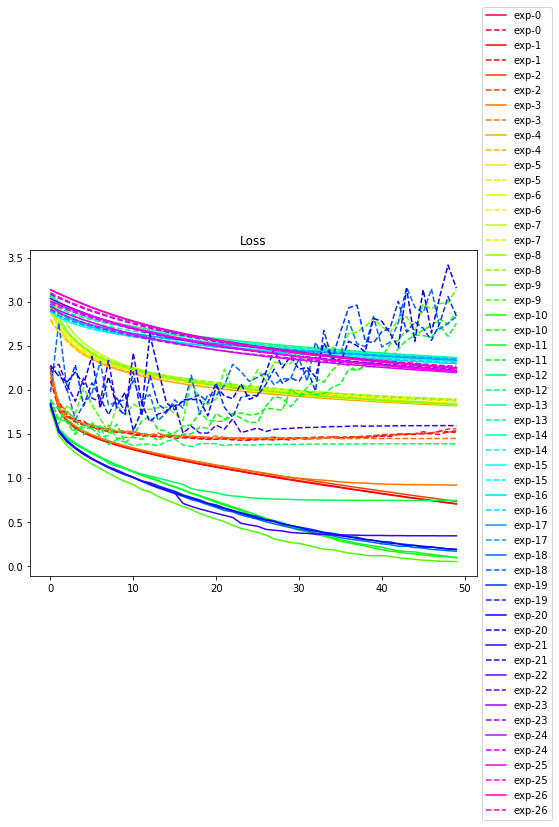

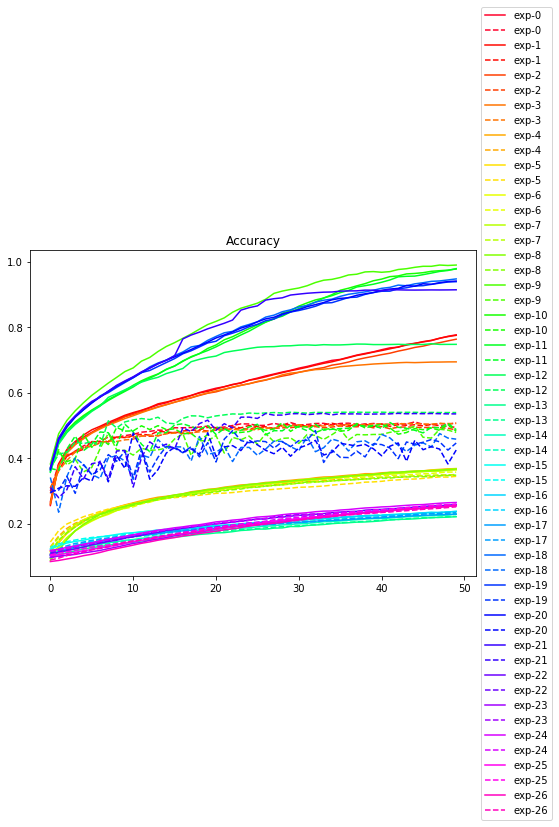

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()